# Tests using real data benchmarks

In this notebook, we run a series of experiments using well-known benchmark datasets.

In [1]:
## External modules.
from contextlib import ExitStack
from copy import deepcopy
from json import load as json_load
from matplotlib import cm
from matplotlib.colors import BoundaryNorm
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import ConfusionMatrixDisplay

## Internal modules.
from mml.utils import makedir_safe
from mml.utils.mest import scale_madmed
from setup_data import get_data
from setup_losses import get_loss
from setup_models import get_model
from setup_results import img_dir, results_dir, my_fontsize, my_ext, export_legend

In [2]:
## Specify the risk classes we want to consider.
riskclasses = ["erm", "triskSigL", "meanvar"]

risk_names = {"erm": "ERM",
              "meanvar": "Mean-Variance",
              "rrisk": "M-risk",
              "trisk": "T-risk",
              "triskSigS": "T-risk",
              "triskSigM": "T-risk",
              "triskSigL": "T-risk",
              "triskCustom": "triskCustom",
              "cvar": "CVaR risk",
              "entropic": "Tilted risk",
              "dro": r"$\chi^{2}$-DRO risk"}

In [3]:
## Choose the dataset we want to consider.
dataset = "iris"

In [4]:
## Choose a risk class, model, and learning algorithm combination.
loss_base = "logistic" # specify base loss name.
model = "linreg_multi" # specify model name
algo = "SGD_Ave" # specify algo name

In [5]:
## Directory setup.
makedir_safe(img_dir)
toread_dir = os.path.join(results_dir, dataset)

In [6]:
## Specify the evaluation metrics to look at (for selecting "best settings").
ltype = "obj"
etypes = ["train", "val", "test"]

In [7]:
## Specify which epoch to use.
epoch_touse = -1

In [8]:
## Specify the statistic index to use (for selection).
stat_idx = 0 # mean is 0, median is 1, std is 2.

## Specify the statistic index to use (for visualization).
stat_idx_vis = 0 # mean is 0, median is 1, std is 2.

In [9]:
## Linestyles for discriminating train/val/test.
linestyles = {"train": "dotted",
              "val": "dashed",
              "test": "solid"}

In [10]:
## Extras naming etc.
extras_keys = {"erm": [],
               "meanvar": [],
               "rrisk": ["alpha"],
               "trisk": ["alpha"],
               "triskSigS":  ["alpha"],
               "triskSigM":  ["alpha"],
               "triskSigL":  ["alpha"],
               "triskCustom": ["alpha"],
               "cvar": ["prob"],
               "entropic": ["gamma"],
               "dro": ["atilde"]}

extras_symbols = {"erm": [],
                  "meanvar": [],
                  "rrisk": [r"$\alpha$"],
                  "trisk": [r"$\alpha$"],
                  "triskSigS": [r"$\alpha$"],
                  "triskSigM":  [r"$\alpha$"],
                  "triskSigL": [r"$\alpha$"],
                  "triskCustom": [r"$\alpha$"],
                  "cvar": [r"$\beta$"],
                  "entropic": [r"$\gamma$"],
                  "dro": [r"$\widetilde{a}$"]}

def parse_extras(extras, risk_name):
    if risk_name in ["erm", "meanvar"]:
        return None
    elif risk_name == "rrisk":
        return r"$\alpha=${}".format(extras["alpha"])
    elif risk_name in ["trisk", "triskSigS", "triskSigM", "triskSigL", "triskCustom"]:
        return r"$\alpha=${}".format(extras["alpha"])
    elif risk_name == "cvar":
        return r"$\beta=${}".format(extras["prob"])
    elif risk_name == "entropic":
        return r"$\gamma=${}".format(extras["gamma"])
    elif risk_name == "dro":
        return r"$\widetilde a=${}".format(extras["atilde"])
    else:
        raise ValueError("Please pass a valid risk name.")

In [11]:
## Dictionary for storing the best/representative settings for each risk class.
best_settings = {riskclass: [] for riskclass in riskclasses}

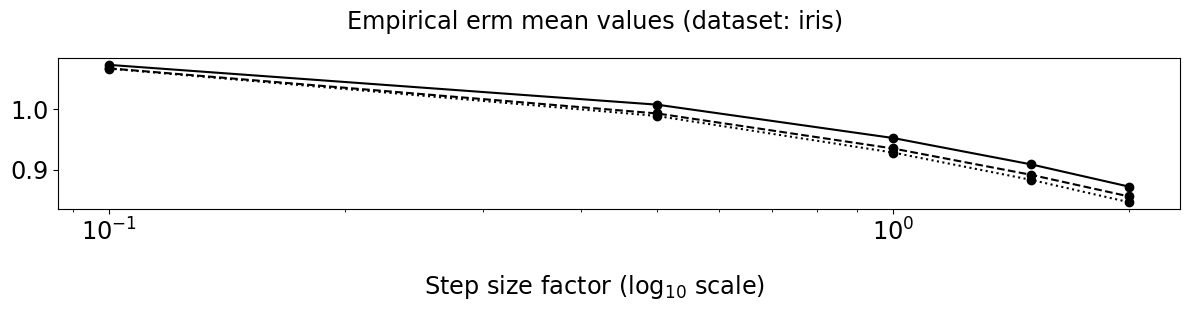

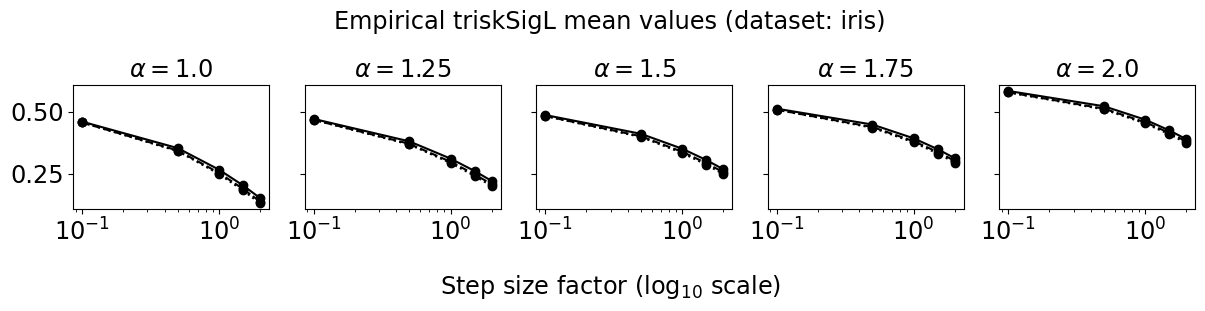

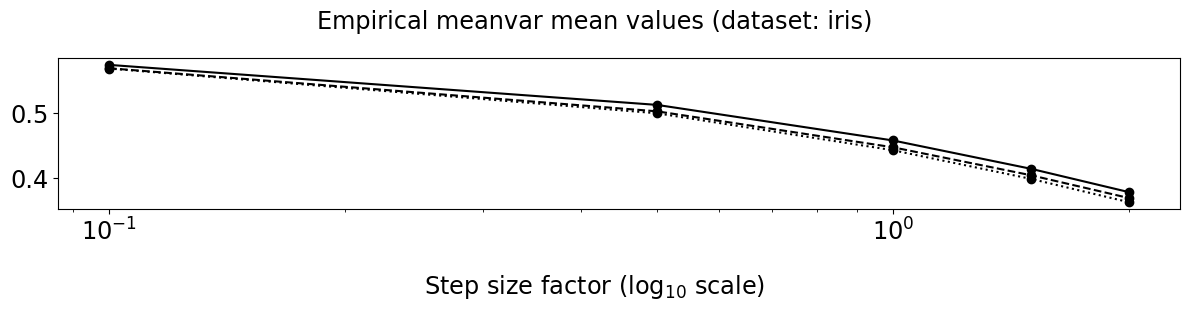

In [12]:
## Gathering, processing, and visualization all handled in one big loop.

for riskclass in riskclasses:
    
    ## Most of the filename is already specified.
    mth_base = riskclass+"_"+loss_base+"_"+model+"_"+algo
    
    ## Initialize a dict of results.
    results_dict = {}
    
    ## Gather the relevant hyperparameter indices to be parsed.
    all_files = os.listdir(toread_dir)
    r_values = []
    s_values = []
    for filename in all_files:
        _mth, extension = filename.split(".")
        if extension == "json":
            task, _mth_base = _mth.split("-")
            if mth_base == _mth_base:
                s_value, r_value = task.split("s")[1].split("r")
                if r_value not in r_values:
                    r_values += [r_value]
                if s_value not in s_values:
                    s_values += [s_value]
            else:
                continue
        else:
            continue
    num_r = len(r_values)
    num_s = len(s_values)
    if num_r > 0 and num_s > 0:
        ## Convert to integers, and sort.
        r_values = sorted([int(r) for r in r_values])
        s_values = sorted([int(s) for s in s_values])
    else:
        print("No results found for '{}' dataset.".format(dataset))
        continue
    
    ## Initial prep of the figure.
    fig, axes = plt.subplots(1, num_r, figsize=(12,3), sharex=True, sharey=True)
    
    ## Now we can just loop over the relevant files.
    for i, r in enumerate(r_values):
        
        ## Relevant axis.
        ax = axes[i] if num_r > 1 else axes
        
        ## Storage for values to be plotted.
        x_values = []
        y_values_dict = {etype: [] for etype in etypes}
        
        for s in s_values:
            
            task = "s{}r{}".format(s, r)
            mth = "-".join([task, mth_base])
            
            ## Gather relevant information from the experiment JSON file.
            with open(os.path.join(toread_dir, ".".join([mth, "json"])), "r", encoding="utf-8") as f:
                json_dict = json_load(f)
                num_trials = json_dict["num_trials"]
                x_values += [json_dict["step_size"]]
                
                if s == 0:
                    ## Get risk function parameters at first inner step.
                    extras = {key: json_dict[key] for key in extras_keys[riskclass]}
                else:
                    ## After that, make sure they all match.
                    if not all([extras[key] == json_dict[key] for key in extras_keys[riskclass]]):
                        raise ValueError("Extras don't match.")
            
            ## Initialize a list for this specific risk setting.
            results = {etype: [] for etype in etypes}
            
            ## Gather the results of interest.
            for etype in results:
                for trial in range(num_trials):
                    ## Read in the results, add to a list that will be stacked soon.
                    fname = mth+"-"+str(trial)+"."+ltype+"_"+etype
                    with open(os.path.join(toread_dir, fname), "r", encoding="utf-8") as f:
                        values = np.loadtxt(fname=f, dtype=float, delimiter=",", ndmin=2)
                        ## Add results for the current trial.
                        results[etype] += [np.expand_dims(a=values, axis=0)]
                ## Having covered all trials, stack and process the arrays.
                y_values_dict[etype] += [ np.vstack(results[etype]).mean(axis=0)[epoch_touse,stat_idx] ]
                
            
        ## Plot these results.
        x_values = np.array(x_values)
        for etype in results:
            y_values = np.array(y_values_dict[etype])
            ax.semilogx(x_values, y_values, base=10, marker="o",
                        color="xkcd:black", ls=linestyles[etype])
        ax.tick_params(labelsize=my_fontsize)
        ax.set_title(parse_extras(extras=extras, risk_name=riskclass), size=my_fontsize)
        
        ## Store the best task.
        try:
            best_settings[riskclass] += ["s{}r{}".format(np.nanargmin(y_values_dict["val"]), r)]
        except ValueError:
            best_settings[riskclass] += [None]
    
        
    ## Title and horizontal axis label for the figure.
    fig.supxlabel(r"Step size factor ($\log_{10}$ scale)", size=my_fontsize)
    fig.suptitle("Empirical {} mean values (dataset: {})".format(riskclass, dataset), size=my_fontsize)
    
    ## Display the figure.
    plt.tight_layout()
    plt.show()

Next, we visualize the trajectory (over time) of several key evaluation metrics of interest.

In [13]:
## Specify the risks for which we want to visualize trajectories.
riskclasses_tovis = ["erm", "triskSigL", "meanvar"]

In [14]:
## Specify the evaluation metrics to look at (from ["base", "obj", "zeroone", "confuse", "l1", "l2"]).
ltypes = ["base", "zeroone", "confuse"]
ltypes_tovis = ["base", "zeroone"]
etype = "test" # either "train", "val", or "test"

In [15]:
## Prepare a dictionary for storing results.
results_allrisks = {}
json_dicts_allrisks = {}

In [16]:
## Gathering of results (for trajectories).

for riskclass in riskclasses_tovis:
    
    ## Initialize a list of results for each risk class.
    results_list = []
    json_dicts = []
    
    ## Grab the representative results.
    for task in best_settings[riskclass]:
        
        if task is None:
            print("Risk {}: task is none here; skipping.".format(riskclass))
            continue
        
        ## Identify the method for which we will gather results.
        mth = task+"-"+riskclass+"_"+loss_base+"_"+model+"_"+algo
        
        ## Gather relevant information from the experiment JSON file.
        with open(os.path.join(toread_dir, ".".join([mth, "json"])), "r", encoding="utf-8") as f:
            json_dict = json_load(f)
            num_trials = json_dict["num_trials"]
            
        ## Initialize a dictionary for this specific risk setting.
        results = {ltype: [] for ltype in ltypes}
        
        ## Gather the results of interest.
        for ltype in ltypes:
            for trial in range(num_trials):
                ## Read in the results, add to a list that will be stacked soon.
                fname = mth+"-"+str(trial)+"."+ltype+"_"+etype
                with open(os.path.join(toread_dir, fname), "r", encoding="utf-8") as f:
                    values = np.loadtxt(fname=f, dtype=float, delimiter=",", ndmin=2)
                    shape = values.shape
                ## Add results for the current trial.
                results[ltype] += [np.expand_dims(a=values, axis=0)]
            
            ## Having covered all trials, stack the arrays.
            results[ltype] = np.vstack(results[ltype])
        
        ## Store results for this risk setting.
        results_list += [deepcopy(results)]
        json_dicts += [deepcopy(json_dict)]
    
    ## Finally, store the results dictionary for the current risk class.
    results_allrisks[riskclass] = deepcopy(results_list)
    json_dicts_allrisks[riskclass] = deepcopy(json_dicts)

In [17]:
## Manual limits (top, bottom), for nice-looking figures.

lims_base_ave = {"adult": (None, None),
                 "australian": (None, None),
                 "cifar10": (2.5, None),
                 "covtype": (0.825, 0.6),
                 "emnist_balanced": (3.05, None),
                 "fashion_mnist": (0.75, None),
                 "iris": (None, None),
                 "protein": (0.075, 0.005)}
lims_base_std = {"adult": (None, None),
                 "australian": (None, None),
                 "cifar10": (None, 0.4),
                 "covtype": (None, None),
                 "emnist_balanced": (None, None),
                 "fashion_mnist": (None, None),
                 "iris": (None, None),
                 "protein": (None, None)}
lims_zeroone_ave = {"adult": (0.25, None),
                    "australian": (0.25, None),
                    "cifar10": (0.75, None),
                    "covtype": (0.32, 0.275),
                    "emnist_balanced": (0.55, None),
                    "fashion_mnist": (0.255, None),
                    "iris": (None, None),
                    "protein": (0.1, None)}
lims_zeroone_std = {"adult": (0.4, None),
                    "australian": (0.45, None),
                    "cifar10": (None, 0.45),
                    "covtype": (None, None),
                    "emnist_balanced": (None, 0.45),
                    "fashion_mnist": (None, None),
                    "iris": (None, None),
                    "protein": (None, None)}

lims_ave = {"base": lims_base_ave,
            "zeroone": lims_zeroone_ave}
lims_std = {"base": lims_base_std,
            "zeroone": lims_zeroone_std}

if stat_idx_vis == 0:
    lims = lims_ave
elif stat_idx_vis == 2:
    lims = lims_std
else:
    lims = {"base": {ds: (None, None) for ds in lims_base_ave},
            "zeroone": {ds: (None, None) for ds in lims_base_ave}}

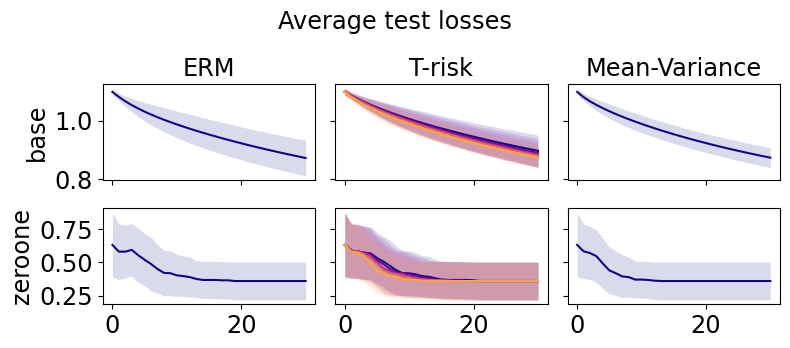

In [18]:
## Visualize the trajectories.

figsize = (8,3.5) # nice size for paper.
#figsize = (20,8) # nice size for viewing here.

fig, axes = plt.subplots(len(ltypes_tovis), len(riskclasses_tovis), figsize=figsize, sharex=True, sharey="row")

## Loop over evaluation metrics.
for i, ltype in enumerate(ltypes_tovis):
    
    ## Row titles.
    axes[i,0].set_ylabel(ltype, size=my_fontsize)
    
    ## Loop over risk classes.
    for j, riskclass in enumerate(riskclasses_tovis):
        
        ## Result lists for this risk class.
        results_list = results_allrisks[riskclass]
        json_dicts = json_dicts_allrisks[riskclass]

        ## Relevant bits of information.
        num_risks = len(results_list)

        ## Color setup.
        cmap = cm.get_cmap("plasma")
        colours = [cmap(k/num_risks) for k in range(num_risks)]
        
        ## Loop over the individual risks.
        for k in range(num_risks):
            
            ## Actual results of interest for plotting.
            results = results_list[k]
            json_dict = json_dicts[k]
            
            ## More relevant bits of information.
            num_epochs = json_dict["num_epochs"]
            
            ## Values to be plotted.
            x_values = np.arange(num_epochs+1)
            y_values = results[ltype].mean(axis=0)[:,stat_idx_vis]
            y_err = results[ltype].std(axis=0)[:,stat_idx_vis]
        
            ## Plot results.
            axes[i,j].plot(x_values, y_values, color=colours[k])
            axes[i,j].fill_between(x=x_values, y1=y_values-y_err, y2=y_values+y_err,
                                   alpha=0.15, color=colours[k], lw=0)
            axes[i,j].set_ylim(top=lims[ltype][dataset][0], bottom=lims[ltype][dataset][1])
        
        ## Column titles.
        axes[i,j].tick_params(labelsize=my_fontsize)
        if i==0:
            axes[i,j].set_title(risk_names[riskclass], size=my_fontsize)

## Title for the figure.
if stat_idx_vis == 0:
    stat_name = "mean"
    fig_title = "Average test losses"
elif stat_idx_vis == 1:
    stat_name = "median"
    fig_title = "Median test losses"
elif stat_idx_vis == 2:
    stat_name = "stdev"
    fig_title = "Standard Deviation of test losses"
else:
    raise ValueError("Provide proper stat_idx_vis value.")
fig.suptitle(fig_title, size=my_fontsize)
fname = os.path.join(img_dir, "real_traj_{}_{}.{}".format(stat_name, dataset, my_ext))
plt.tight_layout()
plt.savefig(fname=fname)
plt.show()

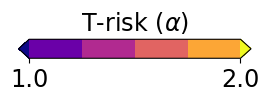

In [19]:
## If desired, we can prepare separate colorbars.
for j, riskclass in enumerate(riskclasses_tovis):
    results_list = results_allrisks[riskclass]
    num_risks = len(results_list)
    if num_risks > 1:
        fig, ax = plt.subplots(figsize=(3, 0.5))
        fig.subplots_adjust(bottom=0.5)
        json_dicts = json_dicts_allrisks[riskclass]
        extras_name = extras_keys[riskclass][0]
        extras_symbol = extras_symbols[riskclass][0]
        bounds = np.array([ json_dicts[k][extras_name] for k in range(num_risks) ])
        cmap = cm.get_cmap("plasma")
        norm = BoundaryNorm(bounds, cmap.N, extend="both")
        cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
                            cax=ax, orientation="horizontal")
        ax.tick_params(labelsize=my_fontsize)
        cbar.set_ticks([bounds.min(), bounds.max()])
        cbar.set_ticklabels([str(bounds.min()), str(bounds.max())])
        ax.set_title("{} ({})".format(risk_names[riskclass],extras_symbol),
                     size=my_fontsize)
        fname = os.path.join(img_dir, "real_colorbar_{}.{}".format(riskclass, my_ext))
        plt.savefig(fname=fname, bbox_inches="tight") # use bbox_inches so text isn't cropped; uncomment to save.
        plt.show()
    else:
        continue

## Confusion matrix after final epoch (averaged over trials)

We've added the code for a nice visualization. Just too many right now; in the end, we will probably want to look at a few individual settings at a time.

=== erm ===
idx: 0


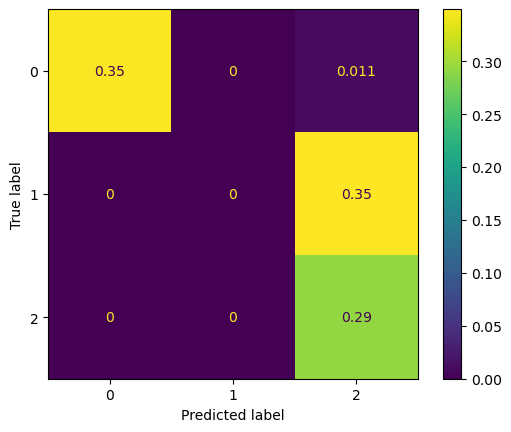

=== triskSigL ===
idx: 0


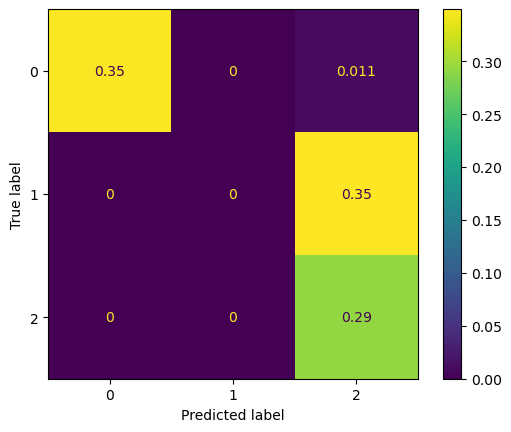

idx: -1


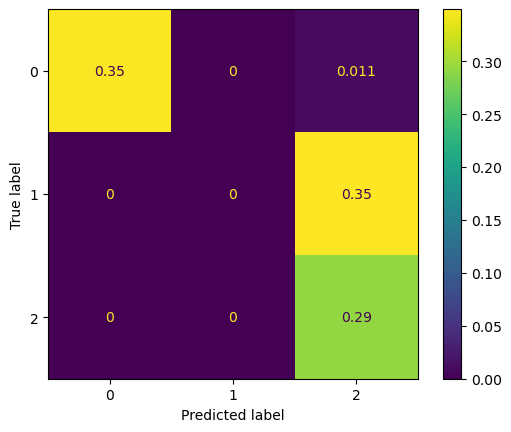

=== meanvar ===
idx: 0


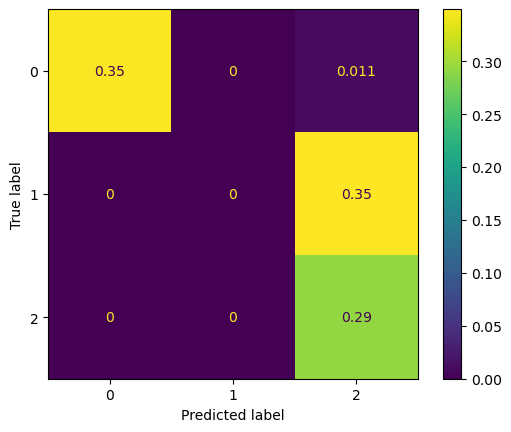

In [20]:
## Print out the confusion matrices.

todo_confusion_idx = {"erm": [0],
                      "meanvar": [0],
                      "triskSigS": [0, -1],
                      "triskSigM": [0, -1],
                      "triskSigL": [0, -1],
                      "triskCustom": [0, -1],
                      "cvar": [0, -1],
                      "entropic": [0, -1],
                      "dro": [0, -1]}

for j, riskclass in enumerate(riskclasses_tovis):
    
    print("===", riskclass, "===")
    
    ## Result lists for this risk class.
    results_list = results_allrisks[riskclass]
    json_dicts = json_dicts_allrisks[riskclass]
    
    ## Relevant bits of information.
    num_risks = len(results_list)
    
    ## Loop over the individual risks.
    for k in todo_confusion_idx[riskclass]:
        
        print("idx:", k)
        
        ## Actual results of interest.
        results = results_list[k]
        json_dict = json_dicts[k]
        cm_disp = ConfusionMatrixDisplay(confusion_matrix=results["confuse"].mean(axis=0))
        cm_disp.plot()
        plt.show()
        #print(results["confuse"].mean(axis=0))
        



## Distribution of base losses

In [21]:
## Specify the trial for which we want to check the distribution.
trial_touse = 0

In [22]:
## Prepare a dictionary for storing results.
results_allrisks = {}
json_dicts_allrisks = {}

In [23]:
## Gathering of results (for distributions).

for riskclass in riskclasses_tovis:
    
    ## Initialize a list of results for each risk class.
    results_list = []
    json_dicts = []
    
    ## Grab the representative results.
    for task in best_settings[riskclass]:
        
        if task is None:
            print("Risk {}: task is none here; skipping.".format(riskclass))
            continue
        
        ## Identify the method for which we will gather results.
        mth = task+"-"+riskclass+"_"+loss_base+"_"+model+"_"+algo
        
        ## Read in the relevant results and store.
        fname = mth+"-"+str(trial_touse)+"."+"dist"+"_"+"test"
        with open(os.path.join(toread_dir, fname), "r", encoding="utf-8") as f:
            ## Store results for this risk setting.
            results_list += [np.loadtxt(fname=f, dtype=float, delimiter=",")]
    
    ## Finally, store the results dictionary for the current risk class.
    results_allrisks[riskclass] = deepcopy(results_list)

/home/mjh/Dropbox/research/code/dev/mml-dev/mml/data/iris/iris.h5 (File) 'iris: Full dataset'
Last modif.: '2021-03-12T07:51:56+00:00'
Object Tree: 
/ (RootGroup) 'iris: Full dataset'
/X (Array(150, 4)) 'iris: Features'
/y (Array(150, 1)) 'iris: Labels'

Type: X (<class 'numpy.ndarray'>)
Type: y (<class 'numpy.ndarray'>)
--Shapes--
n_all: 150 num_features: 4 num_labels: 1
--Subset sizes--
n_train: 120 n_val: 15 n_test: 15
Data types:
X_train: <class 'numpy.ndarray'> y_train: <class 'numpy.ndarray'>
X_val: <class 'numpy.ndarray'> y_val: <class 'numpy.ndarray'>
X_test: <class 'numpy.ndarray'> y_test: <class 'numpy.ndarray'>
Shape of parameter 'w': (4, 3)


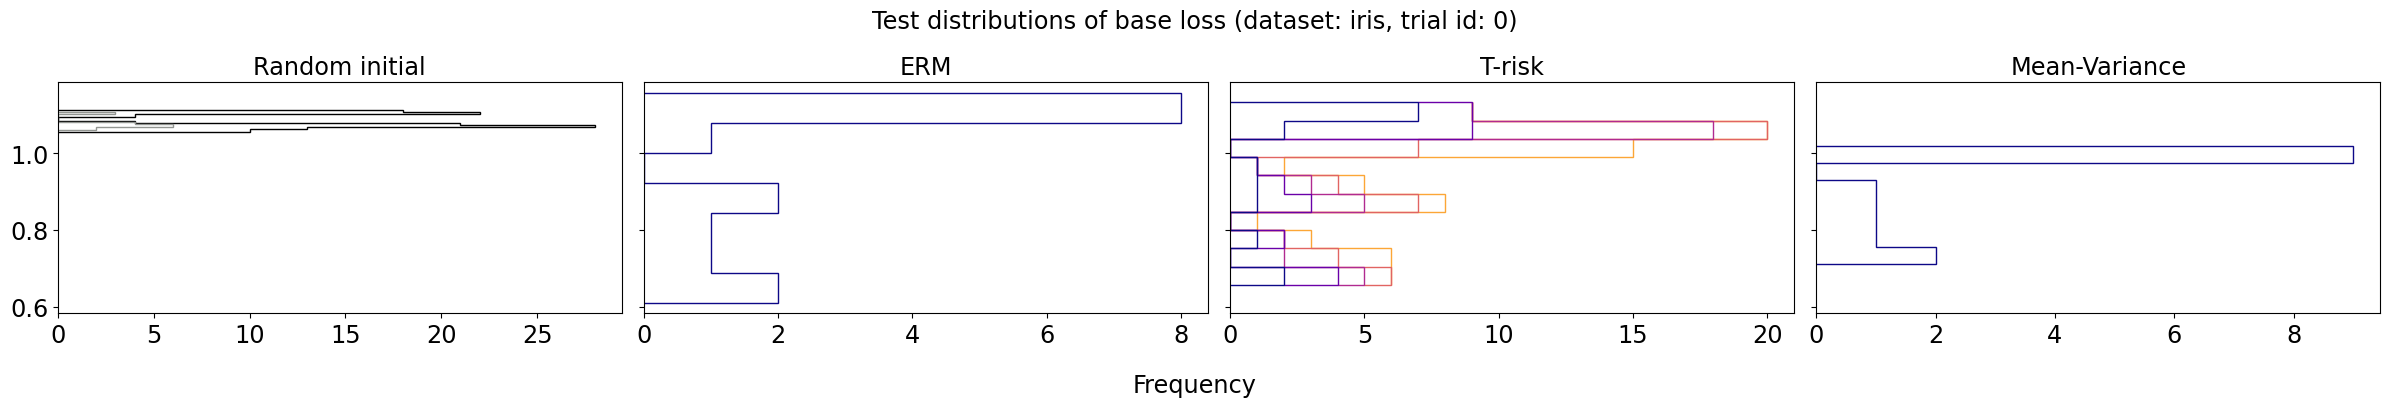

In [24]:
## Visualize the distributions.

#figsize = (12,3)
figsize = (24, 4)

fig, axes = plt.subplots(1, len(riskclasses_tovis)+1, figsize=figsize, sharey=True)

## Prep a random generator object.
entropy = 21281555010861417500927421083615113141
rg = np.random.default_rng(seed=np.random.SeedSequence(entropy=entropy)) # Use this for a pre-fixed seed.
#rg = np.random.default_rng() # Use this for a randomized seed.

## Prepare the dataset.
if len(dataset.split("-")) > 1 and dataset.split("-")[1] == "noisy":
    ref_dataset = dataset.split("-")[0]
    noisy_label_rate = 0.15
else:
    ref_dataset = dataset
    noisy_label_rate = 0.0
(X_train, y_train, X_val, y_val, X_test, y_test, ds_paras) = get_data(dataset=ref_dataset,
                                                                      rg=rg,
                                                                      noisy_label_rate=noisy_label_rate)

## Get the base loss object.
loss_kwargs = {"risk_name": "erm"}
ref_loss_base, ref_loss = get_loss(name=loss_base, **loss_kwargs)
    
## Initialize a linear model.
ref_model = get_model(name=model, paras_init=None, rg=rg, **ds_paras, **loss_kwargs)
print("Shape of parameter 'w':", ref_model.paras["w"].shape)
    
## Compute base losses.
losses_tr = ref_loss_base(model=ref_model, X=X_train, y=y_train)
losses_te = ref_loss_base(model=ref_model, X=X_test, y=y_test)

## Plot histogram of initial losses.
ax = axes[0]
ax.hist(losses_tr, bins="doane", color="xkcd:black",
        histtype="step", stacked=True, fill=False,
        hatch=None, orientation="horizontal", density=False)
ax.hist(losses_te, bins="doane", color="xkcd:gray",
        histtype="step", stacked=True, fill=False,
        hatch=None, orientation="horizontal", density=False)
ax.tick_params(labelsize=my_fontsize)
ax.set_title("Random initial", size=my_fontsize)

for j, riskclass in enumerate(riskclasses_tovis):
    
    ## Get axis to plot with.
    ax = axes[j+1]
    
    ## Get result list.
    results_list = results_allrisks[riskclass]
    
    ## Relevant bits of information.
    num_risks = len(results_list)

    ## Color setup.
    cmap = cm.get_cmap("plasma")
    colours = [cmap(k/num_risks) for k in range(num_risks)]
    
    ## Plot all the results for the current risk class.
    ax.hist(results_list, bins="doane", color=colours,
            histtype="step", stacked=True, fill=False,
            hatch=None, orientation="horizontal", density=False)
    ax.tick_params(labelsize=my_fontsize)
    ax.set_title("{}".format(risk_names[riskclass]), size=my_fontsize)

## Title and horizontal label for the figure.
fig.suptitle("Test distributions of base loss (dataset: {}, trial id: {})".format(dataset, trial_touse),
             size=my_fontsize)
fig.supxlabel("Frequency", size=my_fontsize)

fname = os.path.join(img_dir, "real_hist_{}.{}".format(dataset, my_ext))
plt.tight_layout()
plt.savefig(fname=fname)
plt.show()


## Statistics of base losses

In [25]:
## Prepare a dictionary for storing results.
results_allrisks = {}
json_dicts_allrisks = {}

In [26]:
## Gathering of results (for distributions).

for riskclass in riskclasses_tovis:
    
    ## Initialize a list of results for each risk class.
    results_list = []
    
    ## Grab the representative results.
    for task in best_settings[riskclass]:
        
        if task is None:
            print("Risk {}: task is none here; skipping.".format(riskclass))
            continue
        
        ## Prepare some storage.
        loss_means = []
        loss_meds = []
        loss_stds = []
        loss_mads = []
        
        ## Identify the method for which we will gather results.
        mth = task+"-"+riskclass+"_"+loss_base+"_"+model+"_"+algo
        
        ## Get number of trials run.
        with open(os.path.join(toread_dir, ".".join([mth, "json"])), "r", encoding="utf-8") as f:
            json_dict = json_load(f)
            num_trials = json_dict["num_trials"]
        
        for trial in [0]: # Ah... only storing ONE trial's worth of distributions.    range(num_trials):
            ## Read in the relevant results and store.
            fname = mth+"-"+str(trial)+"."+"dist"+"_"+"test"
            with open(os.path.join(toread_dir, fname), "r", encoding="utf-8") as f:
                ## Compute statistics.
                losses = np.loadtxt(fname=f, dtype=float, delimiter=",")
                loss_means += [np.mean(losses)]
                loss_meds += [np.median(losses)]
                loss_stds += [np.std(losses)]
                loss_mads += [scale_madmed(losses)]
                
        ## After all trials are covered, average over trials.
        results_list += [(np.mean(np.array(loss_means)),
                          np.mean(np.array(loss_meds)),
                          np.mean(np.array(loss_stds)),
                          np.mean(np.array(loss_mads)))]
    
    ## Finally, store the results dictionary for the current risk class.
    results_allrisks[riskclass] = deepcopy(results_list)

In [27]:
## Print out these results.
print("== {} ==".format(dataset))
for riskclass in riskclasses_tovis:
    print(riskclass)
    results = results_allrisks[riskclass]
    for i in range(len(results)):
        print(results[i])

== iris ==
erm
(0.9732016086666666, 1.0949057, 0.18803336260322942, 0.03801999999999994)
triskSigL
(0.9831753006666666, 1.0832268, 0.15876291975407406, 0.03173570000000003)
(0.9679779013333332, 1.0634199, 0.14817997166551797, 0.02936329999999998)
(0.9541448346666666, 1.0436487, 0.13639400521648418, 0.026733999999999813)
(0.9407984893333333, 1.0236809, 0.12411326374651457, 0.02403120000000003)
(0.9238638373333334, 0.99783932, 0.10874585323466543, 0.018428180000000127)
meanvar
(0.9234867346666665, 0.99844525, 0.10992284377634809, 0.01878045000000006)


___